Vérification empirique des résultats du modèle de Solow pour les pays de l'OCDE et de l'UA

Préparation des données

Dans le cadre de ce projet, l'objectif est d'analyser les performances des pays de l'OCDE et de l'Union Africaine à travers une vérification empirique des résultats du modèle de Solow, en s'appuyant sur les conclusions de l'article de Mankiw, Romer et Weil (1992). Pour cela, une étape essentielle consiste à constituer des bases de données robustes et fiables, nécessaires pour mener des analyses statistiques et des modélisations pertinentes.

La phase de préparation des données regroupe deux volets principaux : la récupération des données et leur traitement. Les données ont été collectées principalement à partir de l'API de la Banque Mondiale, complétées et structurées pour répondre aux exigences du modèle de Solow. Cette étape inclut également un travail de nettoyage approfondi afin de résoudre les problèmes courants tels que les valeurs manquantes, les incohérences ou les doublons. Enfin, des transformations et créations de variables clés ont été réalisées pour faciliter leur interprétation et leur exploitation dans les phases ultérieures du projet.

Cette partie vise ainsi à fournir un jeu de données fiable, homogène et prêt à l'analyse, tout en justifiant les choix méthodologiques adoptés à chaque étape.

I- Installation des packages
Pour effectuer les différentes étapes de récupération, traitement et nettoyage des données, plusieurs bibliothèques Python seront utilisées. Voici les principaux packages nécessaires, accompagnés d'une brève explication de leur rôle dans le projet :

pandas : pour la manipulation, le traitement et la structuration des données tabulaires. Il sera essentiel pour charger, nettoyer et exporter les données dans des formats adaptés.
numpy : pour les opérations mathématiques et statistiques de base sur les données.
requests : pour interagir avec l'API de la Banque Mondiale et effectuer les appels HTTP nécessaires pour récupérer les données.
json : pour traiter les réponses au format JSON issues de l'API.
matplotlib et seaborn : pour visualiser les distributions, identifier les anomalies et générer des graphiques descriptifs pour explorer les données.
os : pour gérer les fichiers locaux et organiser les données sauvegardées.
scipy : pour des fonctions statistiques supplémentaires, notamment pour traiter les valeurs aberrantes ou effectuer des imputations avancées.

In [ ]:
pip install pandas requests matplotlib seaborn numpy json os scipy 


     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.8 kB ? eta -:--:--
     ------------ ------------------------- 20.5/60.8 kB 165.2 kB/s eta 0:00:01
     ------------------------- ------------ 41.0/60.8 kB 281.8 kB/s eta 0:00:01
     -------------------------------------- 60.8/60.8 kB 324.0 kB/s eta 0:00:00
   ---------------------------------------- 0.0/44.8 MB ? eta -:--:--
   ---------------------------------------- 0.2/44.8 MB 3.9 MB/s eta 0:00:12
   ---------------------------------------- 0.4/44.8 MB 4.8 MB/s eta 0:00:10
    --------------------------------------- 0.7/44.8 MB 5.0 MB/s eta 0:00:09
    --------------------------------------- 1.0/44.8 MB 5.3 MB/s eta 0:00:09
   - -------------------------------------- 1.6/44.8 MB 6.6 MB/s eta 0:00:07
   - -------------------------------------- 2.2/44.8 MB 7.6 MB/s eta 0:00:06
   -- ------------------------------------- 2.9/44.8 MB 8.7 MB/s eta 0:00:05
   ---


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\ALEX\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


II-Construction de base de données

Dans le cadre de notre étude, nous allons récupérer les données suivantes depuis l'API de la Banque Mondiale : la population par tête, le taux d'épargne, le taux démographique, ainsi que les indicateurs suivants :

"GDP (constant 2015 US$)": NY.GDP.MKTP.KD

"Gross Fixed Capital Formation (constant 2015 US$)": NE.GDI.FTOT.KD

"Population ages 15-64, total": SP.POP.1564.TO

"Gross Fixed Capital Formation (% GDP)": NE.GDI.FTOT.ZS

Nous allons créer deux bases de données distinctes : l'une pour les pays de l'OCDE et l'autre pour les pays de l'Union Africaine. La base de données pour les 38 pays de l'OCDE sera nommée ocde_data, tandis que celle pour les 55 pays de l'Union Africaine sera nommée ua_data. Le code ci-dessous permet de récupérer ces deux bases de données.


In [13]:
import requests
import pandas as pd

def fetch_worldbank_data(countries, indicators, start_year, end_year):
    """
    Télécharge les données de l'API de la Banque mondiale pour une liste d'indicateurs et des pays.
    Args:
        countries (str): Liste de codes ISO des pays séparés par ';' (ex: 'USA;FRA;DEU').
        indicators (dict): Dictionnaire des indicateurs (nom: code WB).
        start_year (int): Année de début.
        end_year (int): Année de fin.
    Returns:
        pd.DataFrame: Base de données combinée avec toutes les variables.
    """
    # Créer un DataFrame pour tout regrouper
    combined_df = pd.DataFrame()

    for name, indicator in indicators.items():
        print(f"Téléchargement des données pour : {name}")
        url = f"http://api.worldbank.org/v2/country/{countries}/indicator/{indicator}?date={start_year}:{end_year}&format=json&per_page=1000"
        response = requests.get(url)
        
        if response.status_code != 200:
            raise Exception(f"Erreur lors de la requête API : {response.status_code}")
        
        data = response.json()
        if len(data) < 2 or not data[1]:
            print(f"Aucune donnée disponible pour {name}")
            continue
        
        # Extraire et normaliser les données
        records = data[1]
        df = pd.json_normalize(records)
        df = df[['country.value', 'date', 'value']].rename(columns={
            'country.value': 'Country',
            'date': 'Year',
            'value': name  # Nom de la variable pour la colonne
        })
        
        # Fusionner avec les données existantes
        if combined_df.empty:
            combined_df = df
        else:
            combined_df = pd.merge(combined_df, df, on=['Country', 'Year'], how='outer')
    
    # Trier les données par pays et année
    combined_df = combined_df.sort_values(by=['Country', 'Year']).reset_index(drop=True)
    return combined_df

# Étape 1 : Codes des pays pour l'OCDE et l'Union Africaine
# Liste complète des pays de l'OCDE et de l'Union Africaine
ocde_countries = "DEU;AUS;AUT;BEL;CAN;CHL;COL;KOR;CRI;DNK;ESP;EST;USA;FIN;FRA;GRC;HUN;IRL;ISL;ISR;ITA;JPN;LVA;LTU;LUX;MEX;NOR;NZL;NLD;POL;PRT;CZE;GBR;SVK;SVN;SWE;CHE;TUR"
ua_countries = "ZAF;DZA;AGO;BEN;BWA;BFA;BDI;CPV;CMR;COM;COG;COD;CIV;DJI;EGY;ERI;SWZ;ETH;GAB;GMB;GHA;GIN;GNB;GNQ;KEN;LSO;LBR;LBY;MDG;MWI;MLI;MAR;MUS;MRT;MOZ;NAM;NER;NGA;UGA;RWA;STP;SEN;SYC;SLE;SOM;SDN;SSD;TZA;TCD;TGO;TUN;ZMB;ZWE"

# Étape 2 : Variables à récupérer
indicators = {
    "Population": "SP.POP.TOTL",
    "Taux d'épargne": "NY.GNS.ICTR.ZS",
    "Taux de croissance démographique": "SP.POP.GROW",
    "GDP (constant 2015 US$)": "NY.GDP.MKTP.KD",
    "Gross Fixed Capital Formation (constant 2015 US$)": "NE.GDI.FTOT.KD",
    "Population ages 15-64, total": "SP.POP.1564.TO",
    "Gross Fixed Capital Formation (% GDP)": "NE.GDI.FTOT.ZS"
}

# Étape 3 : Récupérer les données
start_year = 1990
end_year = 2023

print("Téléchargement des données pour les pays de l'OCDE...")
ocde_data = fetch_worldbank_data(ocde_countries, indicators, start_year, end_year)

print("Téléchargement des données pour les pays de l'Union Africaine...")
ua_data = fetch_worldbank_data(ua_countries, indicators, start_year, end_year)

# Étape 4 : Sauvegarde des bases en CSV
ocde_data.to_csv('ocde_data.csv', index=False)
ua_data.to_csv('ua_data.csv', index=False)

print("Données OCDE et Union Africaine sauvegardées.")


Téléchargement des données pour les pays de l'OCDE...
Téléchargement des données pour : Population
Téléchargement des données pour : Taux d'épargne
Téléchargement des données pour : Taux de croissance démographique
Téléchargement des données pour : GDP (constant 2015 US$)
Téléchargement des données pour : Gross Fixed Capital Formation (constant 2015 US$)
Téléchargement des données pour : Population ages 15-64, total
Téléchargement des données pour : Gross Fixed Capital Formation (% GDP)
Téléchargement des données pour les pays de l'Union Africaine...
Téléchargement des données pour : Population
Téléchargement des données pour : Taux d'épargne
Téléchargement des données pour : Taux de croissance démographique
Téléchargement des données pour : GDP (constant 2015 US$)
Téléchargement des données pour : Gross Fixed Capital Formation (constant 2015 US$)
Téléchargement des données pour : Population ages 15-64, total
Téléchargement des données pour : Gross Fixed Capital Formation (% GDP)
Donné

Visualisation des deux bases de données.

In [14]:
ocde_data

,Country,Year,Population,Taux d'épargne,Taux de croissance démographique,GDP (constant 2015 US$),Gross Fixed Capital Formation (constant 2015 US$),"Population ages 15-64, total",Gross Fixed Capital Formation (% GDP)
0,Australia,1990,17065128,24.447638,1.480047,6.294857e+11,1.285972e+11,11415078,27.660831
1,Australia,1991,17284036,20.836339,1.274622,6.270818e+11,1.164060e+11,11549946,24.568707
2,Australia,1992,17478635,18.342149,1.119598,6.297637e+11,1.117528e+11,11664387,22.839032
3,Australia,1993,17634808,20.331848,0.889540,6.552386e+11,1.191678e+11,11754306,23.486058
4,Australia,1994,17805468,21.877939,0.963092,6.813152e+11,1.260712e+11,11858713,23.965144
...,...,...,...,...,...,...,...,...,...
995,United Kingdom,2019,66836327,15.688148,0.564131,3.157388e+12,5.628326e+11,42504702,18.193258
996,United Kingdom,2020,67081234,14.703853,0.365758,2.830286e+12,5.022235e+11,42589297,17.463769
997,United Kingdom,2021,67026292,17.459136,-0.081937,3.075810e+12,5.396074e+11,42509878,17.680956
998,United Kingdom,2022,67791000,16.722697,1.134448,3.209461e+12,5.828838e+11,42954679,18.333260


In [15]:
ua_data

,Country,Year,Population,Taux d'épargne,Taux de croissance démographique,GDP (constant 2015 US$),Gross Fixed Capital Formation (constant 2015 US$),"Population ages 15-64, total",Gross Fixed Capital Formation (% GDP)
0,Algeria,1990,25518074,23.977688,2.494068,9.149723e+10,2.676994e+10,13789483,26.970133
1,Algeria,1991,26133905,32.259322,2.384653,9.039926e+10,2.430406e+10,14250380,25.861457
2,Algeria,1992,26748303,NaN,2.323752,9.202645e+10,2.228820e+10,14710931,27.074986
3,Algeria,1993,27354327,NaN,2.240369,9.009389e+10,2.093612e+10,15182962,27.006860
4,Algeria,1994,27937006,NaN,2.107747,8.928305e+10,2.185831e+10,15668783,28.400938
...,...,...,...,...,...,...,...,...,...
995,Mozambique,2019,30285595,19.633544,2.886567,1.844283e+10,NaN,16155310,NaN
996,Mozambique,2020,31178239,13.554313,2.904820,1.821791e+10,NaN,16691707,NaN
997,Mozambique,2021,32077072,12.528213,2.842112,1.865103e+10,NaN,17234266,NaN
998,Mozambique,2022,32969518,6.164613,2.744193,1.946418e+10,NaN,17774048,NaN


Les deux bases de données contient 1000 lignes et 9 colonnes.

Détections des doublons

In [16]:
# Vérification des doublons
print("Nombre total de doublons dans ocde_data :",
      ocde_data[ocde_data.duplicated()].shape[0])

Nombre total de doublons dans ocde_data : 0


In [17]:
# Vérification des doublons
print("Nombre total de doublons dans ua_data :",
      ua_data[ua_data.duplicated()].shape[0])

Nombre total de doublons dans ua_data : 0


Ainsi nos bases de données ne contiennent pas des doublons.

Détection des valeurs manquantes
1- Utiliser pandas pour détecter les valeurs manquantes
isna() : permet de détecter les valeurs manquantes sous forme de True ou False.

sum() : permet de compter le nombre de valeurs manquantes par colonne.

Le code ci-dessous permet de compter les valeurs pour chaque colonnes.

In [21]:
missing_values1 = ocde_data.isna().sum()
missing_values2 = ua_data.isna().sum()
print("Le nombre de variables manquantes par colonne dans la base des pays de l'ocde ")
print(missing_values1)
print("Le nombre de variables manquantes par colonne dans la base des pays de l'ua ")
print(missing_values2)


Le nombre de variables manquantes par colonne dans la base des pays de l'ocde 
Country                                               0
Year                                                  0
Population                                            0
Taux d'épargne                                       76
Taux de croissance démographique                      0
GDP (constant 2015 US$)                               0
Gross Fixed Capital Formation (constant 2015 US$)    15
Population ages 15-64, total                          0
Gross Fixed Capital Formation (% GDP)                15
dtype: int64
Le nombre de variables manquantes par colonne dans la base des pays de l'ua 
Country                                                0
Year                                                   0
Population                                             0
Taux d'épargne                                       288
Taux de croissance démographique                       0
GDP (constant 2015 US$)                   

2- Visualisation simple des valeurs manquantes avec matplotlib

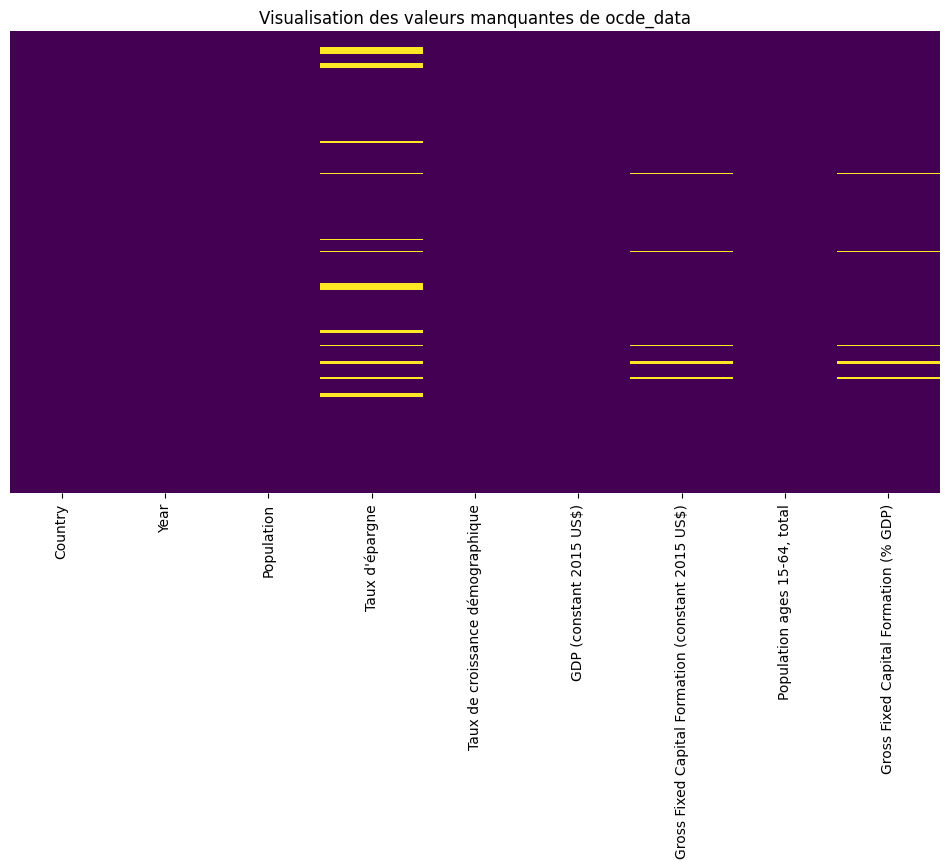

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.heatmap(ocde_data.isna(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("Visualisation des valeurs manquantes de ocde_data")
plt.show()


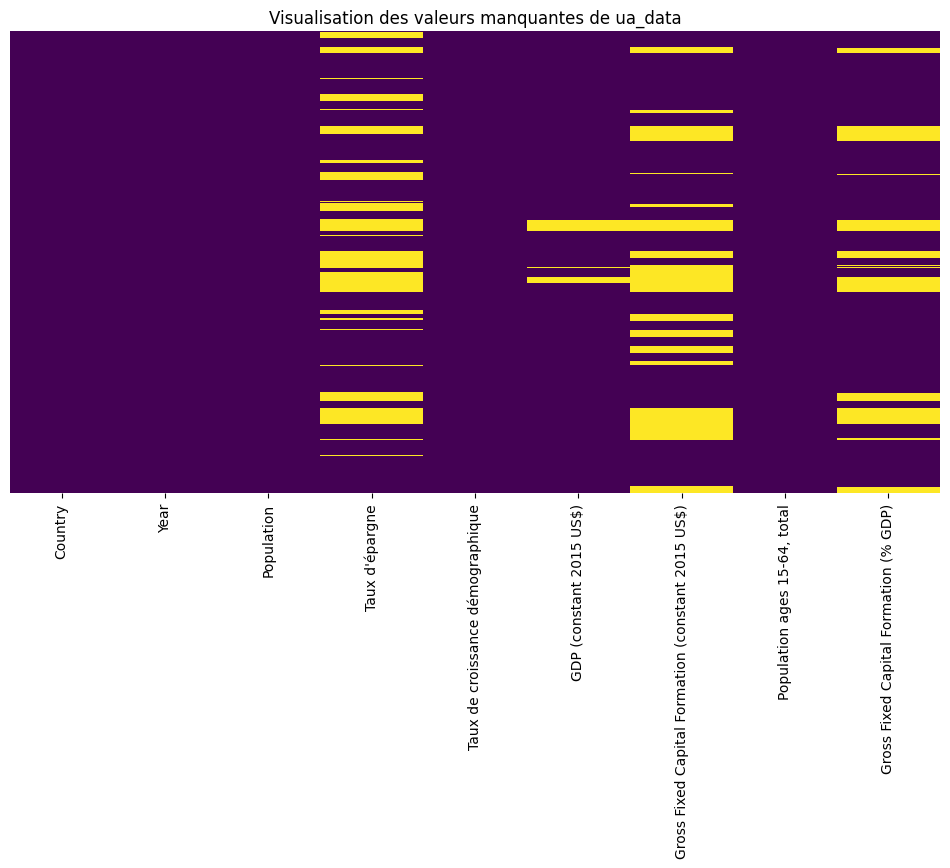

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.heatmap(ua_data.isna(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("Visualisation des valeurs manquantes de ua_data")
plt.show()

Gestion des variables manquantes

Imputation par la moyenne/mediane :

Moyenne pour les variables quantitatives continues comme GDP et Taux d'épargne.

Médiane si les données sont asymétriques (distribution non normale).

In [32]:
# Pour la base des pays de l'OCDE
# Imputation par la moyenne pour les variables quantitatives continues
ocde_data['Taux d\'épargne'] = ocde_data['Taux d\'épargne'].fillna(ocde_data['Taux d\'épargne'].mean())

# Imputation par la médiane pour les variables avec une distribution asymétrique (ex : Capital Formation)
ocde_data['Gross Fixed Capital Formation (constant 2015 US$)'] = ocde_data['Gross Fixed Capital Formation (constant 2015 US$)'].fillna(ocde_data['Gross Fixed Capital Formation (constant 2015 US$)'].median())
ocde_data['Gross Fixed Capital Formation (% GDP)'] = ocde_data['Gross Fixed Capital Formation (% GDP)'].fillna(ocde_data['Gross Fixed Capital Formation (% GDP)'].median())

# Pour la base des pays de l'Union Africaine
# Imputation par la moyenne pour les variables quantitatives continues
ua_data['GDP (constant 2015 US$)'] = ua_data['GDP (constant 2015 US$)'].fillna(ua_data['GDP (constant 2015 US$)'].mean())
ua_data['Taux d\'épargne'] = ua_data['Taux d\'épargne'].fillna(ua_data['Taux d\'épargne'].mean())

# Imputation par la médiane pour les variables avec une distribution asymétrique (ex : Capital Formation)
ua_data['Gross Fixed Capital Formation (constant 2015 US$)'] = ua_data['Gross Fixed Capital Formation (constant 2015 US$)'].fillna(ua_data['Gross Fixed Capital Formation (constant 2015 US$)'].median())
ua_data['Gross Fixed Capital Formation (% GDP)'] = ua_data['Gross Fixed Capital Formation (% GDP)'].fillna(ua_data['Gross Fixed Capital Formation (% GDP)'].median())


Vérification après l'imputation :

In [33]:
missing_values1 = ocde_data.isna().sum()
missing_values2 = ua_data.isna().sum()
print("Le nombre de variables manquantes par colonne dans la base des pays de l'ocde ")
print(missing_values1)
print("Le nombre de variables manquantes par colonne dans la base des pays de l'ua ")
print(missing_values2)

Le nombre de variables manquantes par colonne dans la base des pays de l'ocde 
Country                                              0
Year                                                 0
Population                                           0
Taux d'épargne                                       0
Taux de croissance démographique                     0
GDP (constant 2015 US$)                              0
Gross Fixed Capital Formation (constant 2015 US$)    0
Population ages 15-64, total                         0
Gross Fixed Capital Formation (% GDP)                0
dtype: int64
Le nombre de variables manquantes par colonne dans la base des pays de l'ua 
Country                                              0
Year                                                 0
Population                                           0
Taux d'épargne                                       0
Taux de croissance démographique                     0
GDP (constant 2015 US$)                              0
Gross 